Wayne H Nixalo - 09 Aug 2017

This JNB is an attempt to do the neural artistic style transfer and super-resolution examples done in class, on a GPU using PyTorch for speed.

Lesson NB: [neural-style-pytorch](https://github.com/fastai/courses/blob/master/deeplearning2/neural-style-pytorch.ipynb)

## Neural Style Transfer

Style Transfer / Super Resolution Implementation in PyTorch

In [1]:
%matplotlib inline
import importlib
import os, sys; sys.path.insert(1, os.path.join('../utils'))
from utils2 import *

Using TensorFlow backend.
/home/wnixalo/miniconda3/envs/FAI3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.autograd import Variable
from torch.utils.serialization import load_lua
from torch.utils.data import DataLoader
from torchvision import transforms, models, datasets

### Setup

In [4]:
path = '../data/nst/'
fnames = pickle.load(open(path+'fnames.pkl','rb'))

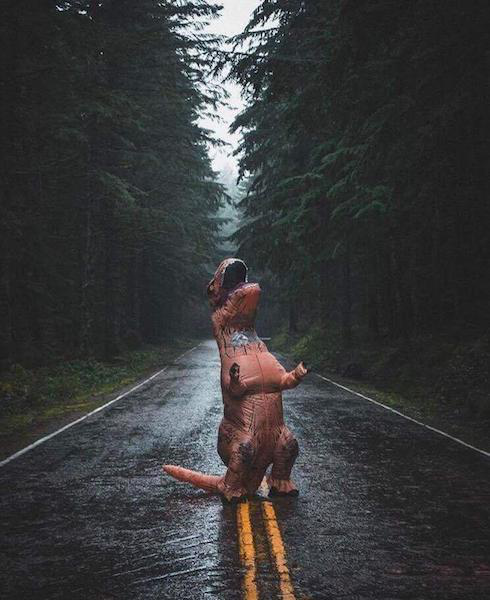

In [6]:
img = Image.open(path + fnames[0]); img

In [7]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((1,1,1,3))
preproc = lambda x: (x - rn_mean)[:,:,:,::-1]

img_arr = preproc(np.expand_dims(np.array(img),0))
shp = img_arr.shape

deproc = lambda x: x[:,:,:,::-1] + rn_mena

### Create Model

In [8]:
def download_convert_vgg16_model():
    model_url = 'http://cs.stanford.edu/people/jcjohns/fast-neural-style/models/vgg16.t7'
    file = get_file(model_url, cache_subdir='models')
    vgglua = load_lua(file).parameters()
    vgg = models.VGGFeature()
    for (src, dst) in zip(vgglua[0], vgg.parameters()): dst[:] = src[:]
    torch.save(vgg.state_dict(), path + 'vgg16_feature.pth')

In [9]:
url = 'https://s3-us-west-2.amazonaws.com/jcjohns-models/'
fname = 'vgg16-00b39a1b.pth'
file = get_file(fname, url+fname, cache_subdir='models')

In [ ]:
vgg = models.vgg.vgg16()
vgg.load_state_dict(torch.load(file))
optimizer = optim.Adam(vgg.parameters())

In [ ]:
vgg.cuda();

In [ ]:
arr_lr = bcolz.open(path + 'trn_resized_72.bc')[:]
arr_hr = bcolz.open(path + 'trn_resized_288.bc')[:]

arr = bcolz.open(dpath + 'trn_resized.bc')[:]

In [ ]:
x = Variable(arr[0])
y = model(x)

In [ ]:
url = 'http://www.files.fast.ai/models/'
fname = 'imagenet_class_index.json'
fpath = get_file(fname, url + fname, cache_subdir='models')

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, num):
        super(ResideualBlock, self).__init__()
        self.c1 = nn.Conv2d(num, num, kernel_size=3, stride=1, padding=1)
        self.c2 = nn.Conv2d(num, num, kernel_size=3, stride=1, padding=1)
        self.b1 = nn.BatchNorm2d(num)
        self.b2 = nn.BatchNorm2d(num)
    
    def forward(self, x):
        h = F.relu(self.b1(self.c1(x)))
        h = self.b2(self.c2(h))
        return h + x

class FastStyleNet(nn.Module):
    def __init__(self):
        super(FastStyleNet, self).__init__()
        self.cs = [nn.Conv2d(3, 32, kernel_size=9, stride=1, padding=4),
                   nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
                   nn.Conv2d(64, 128, kernel_size=4, stride=2, padding1)]
        self.b1s = [nn.BatchNorm2d(i) for i in [32, 64, 128]]
        self.rs = [ResidualBlock(128) for i in range(5)]
        self.ds = [nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
                   nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)]
        self.b2s = [nn.BatchNorm2d(i) for i in [64, 32]]
        self.d3 = nn.Conv2d(32, 3, kernel_size=9, stride=1, padding=4)
    
    def forward(self, h):
        for i in range(3): h = F.relu(self.b1s[i](self.cs[i](x)))
        for r in self.rs: h = r(h)
        for i in range(2): h = F.relu(self.b2s[i](self.ds[i](x)))
        return self.d3(h)

### Loss Functions and Processing